# Arrow Detection in Schemes

### This notebook will be me working through how to detect arrows and their locations in different reaction schemes

In [46]:
import os
import cv2
import math 
import imutils
import json
import copy
import logging

import scipy
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage import io
from skimage import filters
from skimage.transform import rescale, resize
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

from arrow_utils import arrow_average, arrow_centroid, line_mag, get_orientation, get_direction
from image_utils import binary_close, binarize, binary_floodfill, skeletonize, pixel_ratio, skeletonize_area_ratio, pad_image
# from contour_utils import split_contours, show_contours, show_all_contours, find_all_contours
from detection import is_arrow

In [20]:
# Helpful Links 
# https://scikit-learn.org/0.18/auto_examples/cluster/plot_face_segmentation.html
# https://docs.opencv.org/master/d5/d45/tutorial_py_contours_more_functions.html
# Load all the arrows that we have and their respective contours

arrow_dir = os.path.join(os.getcwd(), 'arrows')
list_arrows = sorted(os.listdir(arrow_dir))
list_arrows = list_arrows[2:]
arrows_contour = []
for arrow in list_arrows:
    arrows_image = cv2.imread(os.path.join(arrow_dir, arrow))
    arrows_image = cv2.cvtColor(arrows_image, cv2.COLOR_BGR2GRAY)
    _,threshold = cv2.threshold(arrows_image, 110, 255, cv2.THRESH_BINARY) 
    # Get all the contours on the image
    arrow_cnts,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    for cnt in arrow_cnts:
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True) 
        if len(approx) != 2.5:
            arrows_contour.append(cnt)

In [21]:
# Load all the arrows that we have and their respective contours 
def load_arrows():
    arrow_dir = os.path.join(os.getcwd(), 'arrows')
    list_arrows = sorted(os.listdir(arrow_dir))
    list_arrows = list_arrows[2:]
    arrows_contour = []
    for arrow in list_arrows:
        arrows_image = cv2.imread(os.path.join(arrow_dir, arrow))
        arrows_image = cv2.cvtColor(arrows_image, cv2.COLOR_BGR2GRAY)
        _,threshold = cv2.threshold(arrows_image, 110, 255, cv2.THRESH_BINARY) 
        # Get all the contours on the image
        arrow_cnts,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
        for cnt in arrow_cnts:
            approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True) 
            arrows_contour.append(cnt)
            arrows_contour.append(approx)
    return arrows_contour

arrows_contour = load_arrows()
#arrows_contour = arrows_contour[:43]

In [22]:
# Load Molecules and Chemical Structures
def load_molecules():
    struct_dir = os.path.join(os.getcwd(), 'random_molecules')
    list_structs = sorted(os.listdir(struct_dir))
    list_structs = list_structs[1:]
    molecule_contours = []
    for molecule in list_structs:
        mol_image = cv2.imread(os.path.join(struct_dir, molecule))
        mol_image = cv2.cvtColor(mol_image, cv2.COLOR_BGR2GRAY)
        _,threshold = cv2.threshold(mol_image, 110, 255, cv2.THRESH_BINARY) 
        # Get all the contours on the image
        mol_cnts,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
        for cnt in mol_cnts:
            molecule_contours.append(cnt)
    return molecule_contours

In [49]:
def split_contours(input_contours):
    ''' 
    Method to pad the contours and allow for multiple contours to be passed through 
    the pad image function one at a time. Need this method because of how weird the 
    OpenCV outputs contours 
    
    @PARAM:
        - input_contours: contours that we want to split up. Need to be at least length 1
    @RETURN:
        - if the len(input_contours) > 1, then we return a new list with contours split up
        - Else we return just return the original list for simplicity. 
    
    Note: if input_contours do not have the needed number of contours then the function will
          raise a value error. 
    '''
    if len(input_contours) == 0:
        raise ValueError("Input Contours Need at least 1 contour in them")
    elif len(input_contours) > 1:
        # Return list is the list of all contours
        return_list = []
        for cnt in input_contours:
            # New list is just compartmentalizing all the singular contours
            # Each one should have just length 1
            new_list = []
            new_list.append(cnt)
            return_list.append(new_list)
        return np.array(return_list)
    return np.array(input_contours)

def show_contours(image, list_contours):
    '''
    Draws the contours on the image that is given
    This function will be used when find_arrows only returns 
    the set of contours instead of the image
    
    @PACKAGES:
        - Cv2
    @PARAM:
        - image turned to grayscale of that we have the contours of
        - list_contours: lsit of the contours from find_arrows
    @RETURN:
        - image: the new image with the drawn on contours
    '''
    for cnts in list_contours:
        approx = cv2.approxPolyDP(cnts, 0.01 * cv2.arcLength(cnt, True), True) 
        cv2.drawContours(image, [cnts], 0, (0, 255, 0), 5)
    return image

def show_all_contours(image):
    '''
    Draws all the  contours on the image that is given

    @PACKAGES:
        - CV2: needed for contour extraction
        - numpy: image array handling 
    @PARAM: 
        - image: a numpy array from a cv2 loaded image. Needs to be loaded by cv2 to allow for BGR conversion
                 also will be converted from here
    @RETURN:
        - the image with the drawn in contours. 
    '''
    new_image = np.copy(image)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    _,threshold = cv2.threshold(new_image, 110, 255, cv2.THRESH_BINARY) 
    cnts,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    image = show_contours(image, cnts)
    return image

def find_all_contours(image):
    '''
    Finds all the  contours on the image that is given
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,threshold = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY) 
    cnts,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    return cnts

In [50]:
def find_arrows(image):
    ''' 
    Gets and draws arrow contours from the image onto the image
    Need to work and making it save an image and/or getting the points so we 
    can get the centroid of the shape, thus knowing which side is products and which sides is reactants
    
    @PACKAGES:
        - CV2: needed for contour extraction
        - numpy: image array handling 
    @PARAM: 
        - image: a numpy array from a cv2 loaded image. Needs to be loaded by cv2 to allow for BGR conversion
                 also will be converted from here
    @RETURN:
        - the image with the drawn in contours. Later will make it return the contours so that we can get the 
          
    '''
    list_contours = []
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,threshold = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY)
    # Get all the contours on the image
    cnts,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    for cnt in cnts: 
        area = cv2.contourArea(cnt)
        # Shortlisting the regions based on their area.  
        if area >= 80 and area < 900:
            approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True) 
            # Reaction arrows have 5, 6, 7, or 8 sides so we will use that to narrow it down
            # Also check if it is an arrow after that before drawing contours
            #if len(approx) in [3, 5, 6, 7, 8, 9, 10]:
            list_contours.append(cnt)
                #list_contours.append(approx)
    return list_contours

In [60]:
def pad_image(input_contours, size = 500):
    '''
    Function that will pad a contour in a square image so that 
    we can plug into a formula or neural network. Useful for isolating contours,
    and making a generalized square shape that is easy to work with.
    
    @PACKAGES:
        - cv2: used for the image manipulation and drawing
        - NumPy: used for matrix iperations and intializations
    @PARAM:
        - input_contours: points of contours that we want to draw on the 
                          padded image. 
        - size: size of the square that we want. Image will end up being
                of shape (size, size). Defaults to 500
    @RETURN:
        - padded_image: the new image with the contour drawn in
        
    Note: If you input more than one contour, a ValueError will be raised
    Use the split contours to get the contours in a format that you can manipulate
    '''
    
#     if len(input_contours) != 1:
#         print('Contours Length: ', len(input_contours))
#         raise ValueError("Input Contours Array Needs to be of size 1")
        
    # start with a normal white square with size  
    padded_image = np.ones((size, size))
    input_contours = split_contours(input_contours)
    # Center of the image and the contour 
    center = arrow_centroid(input_contours)
    image_center = (size/2, size/2)
    # Find the difference from the center of the contour to the center 
    # of the of the padded image
    y_change = center[0][0] - image_center[0]
    x_change = center[0][1] - image_center[1]
    for i in range(len(input_contours)):
        for j in range(len(input_contours[i])):
            for k in range(len(input_contours[i][j])):
                # Adjust the contours to align it close to the center
                input_contours[i][j][k][1] = int(input_contours[i][j][k][1] - x_change)
                input_contours[i][j][k][0] = int(input_contours[i][j][k][0] - y_change)
    # Draw the adjusted contours on the new image
    for cnts in input_contours:
        cv2.drawContours(padded_image, [cnts], 0, (0, 255, 0), 5)
    return padded_image

In [51]:
def extraction(image_name = None, image = None):
    '''
    Start of extraction pipeline, from image name to printed contours and 
    an image representation of the arrows identified. Will print all necessary 
    information for the user and will allow the user to see how each image is working
    
    Steps to Pipeline:
    (1) Extract the arrow contours using find_arrow()
    (2) Find the Averages of the points on the arrow
    (3) Find the centroid (absolute middle) of the arrow
        - (2) and (3) will be used to determine direction, 
          whichever side the average is away from the centroid is the direction
          of the arrow pointing
    (4) Find the orientation of the arrow (Horizontal or Vertical)
    (5) Print all the information 
    (6) Show the image with the arrow contours 
    (7) Return the list of contours 
    
    @PARAM:
        - image_name: name of the image we want to run the pipeline on
        - image: Could also supply just loaded Cv2 image, but then dont insert
                the name of the image
                
        Examples:
        
        - If image is already loaded, use this format:
            # Loading Image 
            image = cv2.imread({whatever directory})
            extraction(image = diff_image)
            
            Note: This is preferred method, allows for image to be stored in 
            other directories and makes bulk detection easier
            
        - If you want to use the loading in the function, use this format:
            extraction(image_name = 'image.png')
            
            Note: This format is not as effective, it is better to load the images ahead 
            of time especially if doing bulk conversions
        
    @RETURN:
        - 0 if successful, 1 if there is an issue
    '''
    if image_name != None:
        try:
            image = cv2.imread(os.path.join(os.getcwd(), image_name))
        except error:
            print('Image name is not found, change directory or edit name. Function will stop now')
            return -1, -1, -1, -1, -1
    # Get the arrow contours and then get the necessary information from it
    arrow_contours = find_arrows(image)
    #If we dont find any arrows, return a message
    if len(arrow_contours) == 0:
        print("No arrows were found in the image")
        io.imshow(image)
        return -1, -1, -1, -1, -1
    print('Number of Contours: ', len(arrow_contours), '\n')
    averages = arrow_average(arrow_contours)
    centroids = arrow_centroid(arrow_contours)
    orientation = get_orientation(arrow_contours)
    direction = get_direction(arrow_contours)
#     for contour in range(len(arrow_contours)):
#         print('Arrow Contour ' + str(contour + 1) + ': \n \n', arrow_contours[contour], '\n\n')
    
    print('Arrow Average Points:', averages, '\n')
    print('Arrow Centroid Points: ', centroids, '\n')
    for i in range(len(orientation)):
        print('Arrow ' + str(i + 1) + ' Orientation: ', orientation[i])
    print()
    print(direction)
    print()
    io.imshow(show_contours(np.copy(image), arrow_contours))
    return arrow_contours, averages, centroids, orientation, direction

In [52]:
def define_model():
    ''' 
    Function that creates the Convolutional Neural Network that we need.
    Has 6 convolutional layers, and 2 flattened layers at the end for binary
    classification. Uses a binary crossentropy loss function, and a RMSprop 
    optimizer with a learning rate of 0.001. After 8 training epochs has an accuracy of 
    0.9427. Can definitly add more contours if needed later 
    
    Summary:
    Model: "Sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    conv2d (Conv2D)              (None, 498, 498, 16)      448       
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 249, 249, 16)      0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 247, 247, 32)      4640      
    _________________________________________________________________
    max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
    _________________________________________________________________
    conv2d_2 (Conv2D)            (None, 121, 121, 64)      18496     
    _________________________________________________________________
    max_pooling2d_2 (MaxPooling2 (None, 60, 60, 64)        0         
    _________________________________________________________________
    conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
    _________________________________________________________________
    max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
    _________________________________________________________________
    conv2d_4 (Conv2D)            (None, 27, 27, 64)        36928     
    _________________________________________________________________
    max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
    _________________________________________________________________
    conv2d_5 (Conv2D)            (None, 11, 11, 64)        36928     
    _________________________________________________________________
    max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
    _________________________________________________________________
    flatten (Flatten)            (None, 1600)              0         
    _________________________________________________________________
    dense (Dense)                (None, 256)               409856    
    _________________________________________________________________
    dense_1 (Dense)              (None, 1)                 257       
    =================================================================
    Total params: 544,481
    Trainable params: 544,481
    Non-trainable params: 0
    _________________________________________________________________
    
    @RETURN: the compiled version of this model. Still needs fitting and training later 
             (8-10 epochs, should take about 20-25 min)
    
    '''
    
    model = keras.Sequential()
    # First Convolution
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(500, 500, 3)))
    model.add(MaxPooling2D((2, 2)))
    # Second Convolution
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Third Convolution 
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # The fourth convolution
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # The fifth convolution
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Sixth Convolution (Wow)
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Flatten and feed to a normal DNN
    model.add(Flatten())
    model.add(Dense(256, activation= 'relu'))
    # Gives us value between 0 and 1 for what it thinks
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Use binary crossentropy loss function to create binary classifer
    loss_fn = 'binary_crossentropy'
    opt = RMSprop(lr = 0.001)
    model.compile(optimizer = opt, loss= loss_fn, metrics=['accuracy'])
    
    return model

In [53]:
def pipeline(image, model):
    '''
    Full extraction pipeline, from image name to printed contours and 
    an image representation of the arrows identified. Will print all necessary 
    information for the user and will allow the user to see how each image is working
    
    Steps to Pipeline:
    (1) Extract the arrow contours using find_arrow()
    (2) Find the Averages of the points on the arrow
    (3) Find the centroid (absolute middle) of the arrow
        - (2) and (3) will be used to determine direction, 
          whichever side the average is away from the centroid is the direction
          of the arrow pointing
    (4) Find the orientation of the arrow (Horizontal or Vertical)
    (5) Print all the information 
    (6) Show the image with the arrow contours 
    (7) Return the list of contours 
    
    Steps for Final Pipeline:
    (1) Use previous pipeline to get to get all the potential arrows
    (2) Split the contours, and create padded images for them
    (3) Cache and reload them in correct format
    (4) Use the CNN to filter the potential arrows into the real arrows
    
    @PARAM:
        - image: Could also supply just loaded Cv2 image, but then dont insert
                the name of the image
        - model: Neural network that we want to use to predict. Needs to be fitted and created
                 before hand. 
                
        Examples:
        
        - If image is already loaded, use this format:
            # Loading Image 
            image = cv2.imread({whatever directory})
            pipeline(image = diff_image)
            
            Note: This is preferred method, allows for image to be stored in 
            other directories and makes bulk detection easier

    @RETURN:
        - final_contours: contours of the arrows
        - final_directions: directions of the arrows
        - final_centroids: centroids of the arrow (can be used with direction to determine reaction order)
        
        Note: Also prints these information out, and along with the original pipeline information. 
              If there are no errors from pipeline, then the function will break.
    '''
    # Load all the information
    arrow_contours, averages, centroids, orientation, direction = extraction(image = image)
    if arrow_contours == -1:
        return -1, -1, -1
    # Split contours for padding 
    split = split_contours(arrow_contours)
    split = np.array(split)
    # Because of how CNN was trained, we will save images to load into model
    # Will all be deleted later and does not adversely affect runtime
    try:
        os.makedirs('Images_Cache')
    except FileExistsError:
        os.rmdir("Images_Cache")
        os.makedirs('Images_Cache')

    cache_dir = os.path.join(os.getcwd(), 'Images_Cache')
    for i in range(len(split)):
        image = pad_image(split[i])
        io.imsave(os.path.join(cache_dir, 'testcon' + str(i + 1) + '.png'), image)
    cache = sorted(os.listdir(cache_dir))
    # Read the padded images
    padded_images = []
    for item in cache:
        item_path = os.path.join(cache_dir, item)
        read_image = cv2.imread(item_path)
        padded_images.append(read_image)
        os.remove(item_path)
    # Remove cache 
    os.rmdir("Images_Cache")
    
    # Prepare list of padded images for the model and predict
    padded_images = np.array(padded_images)
    padded_images = padded_images / 255.0
    padded_images = padded_images.reshape(padded_images.shape[0], 500, 500, 3)
    results = model.predict(padded_images)
    
    # Contours that are given a sigmoid score between 0 and 1
    # 0 is a perfect arrow and 1 is absolutly not. For now the barrier is
    # 0.1 for the barrier for the arrow. We will store the indicies in the 
    # final_contours array
    final_contours = []
    conf = []
    for contour in range(len(results)):
        if results[contour] < 0.1:
            final_contours.append(contour)
            conf.append(results[contour])
    final_centroids = []
    final_averages = []
    final_directions = []
    # Add all the information about the arrows that passed the model
    for idx in final_contours:
        final_centroids.append(centroids[idx])
        final_averages.append(averages[idx])
        final_directions.append(direction['Arrow ' + str(idx + 1)])
    
    # Print all the logical informatio (might need to delete later)
    print()
    print("Final Contours Index: ", final_contours)
    print()
    print("Confidence: ", conf)
    print()
    print('Final Centroids', final_centroids)
    print()
    print('Final Averages', final_averages)
    print()
    print('Final Directions', final_directions)
    print()
    return final_contours, final_directions, final_centroids

In [54]:
# Load Data to train Neural Network
class_names = ['Arrow', 'Not Arrow']
arrow_set = os.path.join(os.getcwd(), 'padded_arrows', '1arrows')
not_arrows = os.path.join(os.getcwd(), 'padded_arrows', '1notArrows')
arrow_ims = sorted(os.listdir(arrow_set))[2:]
not_arrow_ims = sorted(os.listdir(not_arrows))[2:]
print('Arrows Length: ', len(arrow_ims))
print('Not Arrows Length: ', len(not_arrow_ims))
training_set = arrow_ims + not_arrow_ims
labels = []
for i in range(len(arrow_ims) + len(not_arrow_ims)):
    if i < len(arrow_ims):
        labels.append(0)
    else:
        labels.append(1)
labels = np.array(labels)

Arrows Length:  1115
Not Arrows Length:  1498


In [55]:
# training_images = []
# for img in arrow_ims:
#     loaded_im = cv2.imread(os.path.join(arrow_set, img))
#     if loaded_im.shape == (500, 500, 3):
#         training_images.append(loaded_im)
#     else:
#         print('Arrow: ' + img)
# for img in not_arrow_ims:
#     loaded_im = cv2.imread(os.path.join(not_arrows, img))
#     if isinstance(loaded_im, type(None)):
#         print("None Type Object: ", img)
#     elif loaded_im.shape != (500, 500, 3):
#         print('Wrong Shape: ', img)
#     else:
#         training_images.append(loaded_im)
# training_images = np.array(training_images)
# training_images = training_images / 255.0
# training_images = training_images.reshape(training_images.shape[0], 500, 500, 3)

In [56]:
# training_images.shape

In [57]:
# Load the model that is needed and trained and work from here. 
# No need to recreate every iteration 
model = keras.models.load_model('model2_new')
model2 = keras.models.load_model('epoch8_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 58, 58, 64)       

In [40]:
#model.fit(training_images, labels, epochs = 5)

/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

Number of Contours:  6 

[(556.5, 106.86440677966101), (324.8329048843188, 65.51156812339332), (136.76271186440678, 53.78813559322034), (581.1015490533563, 69.95352839931154), (23.34020618556701, 39.628865979381445), (441.5, 27.0)]
Arrow Average Points: [(556.5, 106.86440677966101), (324.8329048843188, 65.51156812339332), (136.76271186440678, 53.78813559322034), (581.1015490533563, 69.95352839931154), (23.34020618556701, 39.628865979381445), (441.5, 27.0)] 

Arrow Centroid Points:  [(556.5, 105.0), (323.0, 65.5), (143.0, 55.0), (579.5, 68.5), (23.5, 39.5), (441.5, 27.0)] 

Arrow 1 Orientation:  Horizontal
Arrow 2 Orientation:  Horizontal
Arrow 3 Orientation:  Horizontal
Arrow 4 Orientation:  Horizontal
Arrow 5 Orientation:  Vertical
Arrow 6 Orientation:  Vertical

{'Arrow 1': 'Left', 'Arrow 2': 'Right', 'Arrow 3': 'Left', 'Arrow 4': 'Right', 'Arrow 5': 'Down', 'Arrow 6': 'Up'}


Final Contours Index:  [1]

Confidence:  [array([1.964979e-06], dtype=float32)]

Final Centroids [(323.0, 65

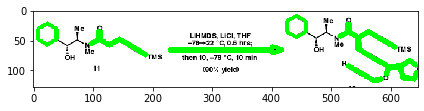

In [61]:
diff_reactions = os.path.join(os.getcwd(), 'testing_set','sample_reactions')
diff_image = cv2.imread(os.path.join(diff_reactions, 'Page10-1.png'))
test_cons = pipeline(image = diff_image, model = model2)

/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anac

Number of Contours:  7 

[(65.78846153846153, 96.65384615384616), (209.7570093457944, 43.08411214953271), (200.5, 31.522727272727273), (361.7307692307692, 42.17307692307692), (387.2676056338028, 40.80281690140845), (83.90566037735849, 42.056603773584904), (109.33802816901408, 40.816901408450704)]
Arrow Average Points: [(65.78846153846153, 96.65384615384616), (209.7570093457944, 43.08411214953271), (200.5, 31.522727272727273), (361.7307692307692, 42.17307692307692), (387.2676056338028, 40.80281690140845), (83.90566037735849, 42.056603773584904), (109.33802816901408, 40.816901408450704)] 

Arrow Centroid Points:  [(66.5, 96.5), (208.0, 43.5), (200.5, 32.0), (361.5, 42.0), (387.5, 41.5), (84.0, 42.0), (109.5, 41.5)] 

Arrow 1 Orientation:  Horizontal
Arrow 2 Orientation:  Horizontal
Arrow 3 Orientation:  Horizontal
Arrow 4 Orientation:  Horizontal
Arrow 5 Orientation:  Horizontal
Arrow 6 Orientation:  Horizontal
Arrow 7 Orientation:  Horizontal

{'Arrow 1': 'Left', 'Arrow 2': 'Right', 'Ar

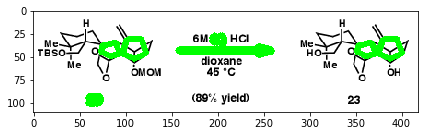

In [62]:
# testing on an example images 
test_dir = os.path.join(os.getcwd(), 'testing_set', 'test_sample_reactions')
listdir = sorted(os.listdir(test_dir))[2:]
image2 = io.imread(os.path.join(test_dir, listdir[2]))
test_cons = pipeline(image = image2, model = model2)

Number of Contours:  15 

[(252.14705882352942, 252.5), (289.6, 236.55714285714285), (23.527027027027028, 218.63513513513513), (268.6930693069307, 216.0), (366.6875, 196.5), (133.46875, 196.5), (339.54545454545456, 184.5064935064935), (49.7787610619469, 188.94690265486724), (291.5735294117647, 189.63970588235293), (94.44, 183.93333333333334), (278.25136612021856, 119.44808743169399), (363.6279069767442, 140.10077519379846), (125.73563218390805, 130.7816091954023), (413.9848484848485, 104.42424242424242), (168.83035714285714, 105.05357142857143)]
Arrow Average Points: [(252.14705882352942, 252.5), (289.6, 236.55714285714285), (23.527027027027028, 218.63513513513513), (268.6930693069307, 216.0), (366.6875, 196.5), (133.46875, 196.5), (339.54545454545456, 184.5064935064935), (49.7787610619469, 188.94690265486724), (291.5735294117647, 189.63970588235293), (94.44, 183.93333333333334), (278.25136612021856, 119.44808743169399), (363.6279069767442, 140.10077519379846), (125.73563218390805, 130

NameError: name 'split_contours' is not defined

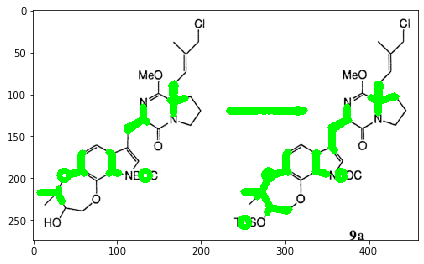

In [48]:
# arrows_image = io.imread(os.path.join(arrow_dir, list_arrows[3]))
# arrow_image = binarize(arrows_image)
# arrow_test = find_contours(arrows_image, 0.8)
# io.imshow(show_contours(arrows_image, arrow_test))
reactions = os.path.join(os.getcwd(), 'testing_set',"ja00073a072_si_001_output", 'images_with_boxes_dpi_100')
list_reactions = sorted(os.listdir(reactions))
diff_image2 = cv2.imread(os.path.join(reactions, list_reactions[4]))
cons1 = pipeline(image = diff_image2, model = model2)

Number of Contours:  81 

[(299.3258426966292, 829.7752808988764), (470.9222222222222, 824.5888888888888), (533.7741935483871, 812.3225806451613), (307.90140845070425, 782.1760563380282), (475.5870967741935, 777.4580645161291), (64.73518518518519, 787.8851851851852), (504.47058823529414, 758.7310924369748), (110.33333333333333, 775.5300546448087), (530.7980769230769, 762.7307692307693), (361.83116883116884, 757.0), (414.03125, 768.0), (77.9375, 672.0), (494.2803738317757, 665.2990654205607), (349.0416666666667, 661.3333333333334), (201.42857142857142, 662.4732142857143), (97.92307692307692, 639.2857142857143), (247.92222222222222, 630.6), (540.0394736842105, 625.5), (396.4886363636364, 627.5113636363636), (208.95876288659792, 612.6907216494845), (360.15441176470586, 618.5955882352941), (497.6666666666667, 611.3953488372093), (60.84023668639053, 632.5562130177515), (523.2077922077922, 602.0519480519481), (552.8510638297872, 600.2021276595744), (115.28828828828829, 597.7747747747748), (5

/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon1.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon2.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: /Users/aryamevada/Documents/SURF/surf-nlp-osr/arrow_detection/Images_Cache/testcon3.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/aryamevada/anac


Final Contours Index:  [2, 13, 15, 17, 18, 29, 33, 35, 50, 51, 52, 55, 80]

Final Centroids [(533.5, 812.5), (349.5, 662.0), (95.5, 637.0), (541.0, 626.5), (395.5, 628.0), (29.0, 514.5), (503.0, 462.5), (538.0, 431.5), (462.5, 234.5), (314.0, 234.5), (376.5, 249.0), (519.5, 229.0), (532.5, 30.5)]

Final Averages [(533.7741935483871, 812.3225806451613), (349.0416666666667, 661.3333333333334), (97.92307692307692, 639.2857142857143), (540.0394736842105, 625.5), (396.4886363636364, 627.5113636363636), (27.132530120481928, 513.8674698795181), (499.91011235955057, 465.1011235955056), (540.8739495798319, 430.38655462184875), (462.3787878787879, 234.8030303030303), (313.921875, 234.90625), (372.1761658031088, 252.5336787564767), (519.0251046025105, 232.0), (533.0238907849829, 32.80204778156997)]

Final Directions ['Up', 'Up', 'Down', 'Up', 'Up', 'Left', 'Down', 'Up', 'Left', 'Left', 'Down', 'Down', 'Right']



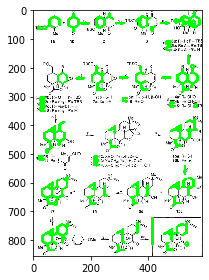

In [292]:
reactions = os.path.join(os.getcwd(), 'testing_set',"ja00047a079_si_001_output", 'images_with_boxes_dpi_100')
list_reactions = sorted(os.listdir(reactions))
diff_image2 = cv2.imread(os.path.join(reactions, list_reactions[2]))
cons1 = pipeline(image = diff_image2, model = model2)

In [118]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
model.predict(test_images)

array([[0.37643138],
       [0.01702847],
       [1.        ],
       [0.99969375],
       [0.00284655],
       [0.3977585 ],
       [0.00106351]], dtype=float32)